In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
data = pd.read_parquet("data/Loan_status_2007-2020Q3.parquet.gzip")

In [3]:
data = data.convert_dtypes()
data

,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,0,1077501,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
1,1,1077430,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
2,2,1077175,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
3,3,1076863,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
4,4,1075358,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925488,105446,102556443,24000,24000,24000.0,60 months,23.99%,690.3,E,E2,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
2925489,105447,102653304,10000,10000,10000.0,36 months,7.99%,313.32,A,A5,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
2925490,105448,102628603,10050,10050,10050.0,36 months,16.99%,358.26,D,D1,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N
2925491,105449,102196576,6000,6000,6000.0,36 months,11.44%,197.69,B,B4,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,N


# Filter data

Нужны статусы: fully paid, write off и default.

In [4]:
set(data["loan_status"])

{<NA>,
 'Charged Off',
 'Current',
 'Default',
 'Does not meet the credit policy. Status:Charged Off',
 'Does not meet the credit policy. Status:Fully Paid',
 'Fully Paid',
 'In Grace Period',
 'Issued',
 'Late (16-30 days)',
 'Late (31-120 days)'}

In [5]:
status_to_use = ['Fully Paid', 'Default', 'Charged Off']
data = data.loc[data['loan_status'].isin(status_to_use)].copy()

# To format

In [6]:
data['revol_util'] = data['revol_util'].str.rstrip('%').astype('float')
data['int_rate'] = data['int_rate'].str.rstrip('%').astype('float')

In [7]:
data.loc[data["term"] == ' 36 months', "term"] = '36'
data.loc[data["term"] == ' 60 months', "term"] = '60'

data["term"] = pd.to_numeric(data["term"])

# Calculate target

Айрат:
В банках обычно моделируют не всю кривую life time, а бинарный таргет 1/0 (был/не было дефолта).
На этих данных нужно сделать аналог.
Если у дефолтника расстояние между last_pymnt_d (последним платежом) и issue_d (the month which the loan was funded) менее 12 месяцев, то ставим 1, иначе 0. То есть либо дефолта не было, либо он произошел за горизонтом 12 месяцев.

In [8]:
data['last_pymnt_d'] = pd.to_datetime(data['last_pymnt_d'])
data['issue_d'] = pd.to_datetime(data['issue_d'])

In [9]:
data['target'] = 0
data.loc[data['loan_status'] != 'Fully Paid', 'target'] = 1

In [10]:
data['target_month'] = data["term"].copy()
data.loc[data['target'] == 1, 'target_month'] = data['last_pymnt_d'].dt.to_period('M').astype(int) - data['issue_d'].dt.to_period('M').astype(int)

In [11]:
data = data[data['target_month'] <= 60].copy()
data.shape

(1857375, 144)

<AxesSubplot:>

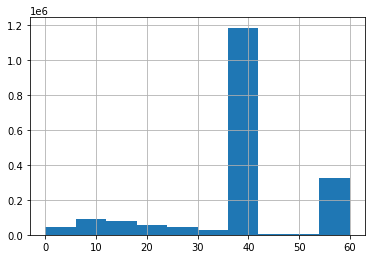

In [12]:
data['target_month'].hist()

In [13]:
data['target_xgb'] = 0
data.loc[((data['last_pymnt_d'] - data['issue_d']) < pd.Timedelta(30 * 12, unit='D')) & (data['target'] == 1), 'target_xgb'] = 1
data['target_xgb'].sum() / data.shape[0]

0.07201022949054445

In [14]:
# data.loc[data['target_xgb'] == 0, 'loan_status'] = "Fully Paid"
# data.loc[data['target_xgb'] == 1, 'loan_status'] = "Charged Off"

In [15]:
# data.to_parquet("data/data_target_4xgb.parquet.gzip", compression='gzip')

# Drop columns

## Meaningless

In [16]:
data.drop(["Unnamed: 0", 'id'], axis=1, inplace=True)

## Leak

In [17]:
leak_columns = [
    "collection_recovery_fee", "funded_amnt", "funded_amnt_inv", "issue_d", "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt", "last_pymnt_d", "out_prncp",
    "out_prncp_inv", "recoveries", "total_pymnt", "total_pymnt_inv", "total_rec_int", "total_rec_late_fee", "total_rec_prncp", "loan_status"
]

data.drop(leak_columns, axis=1, inplace=True)

## Included in other

In [18]:
data.drop(["grade", "title"], axis=1, inplace=True)

## Has only one value

In [19]:
data.drop(["policy_code", "pymnt_plan"], axis=1, inplace=True)

## Too little data and impossible to restore

In [20]:
data.drop(["next_pymnt_d"], axis=1, inplace=True)

# Save data

In [21]:
data.reset_index(inplace=True, drop=True)

In [22]:
data.to_parquet("data/data_target_4xgb.parquet.gzip", compression='gzip')